## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"cat" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [52]:
import requests
import zipfile
import os

# Загрузка zip-файла
url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
response = requests.get(url)

# Сохранение zip-файла
with open("ml-1m.zip", "wb") as f:
    f.write(response.content)

# Распаковка zip-файла и проверка его содержимого
with zipfile.ZipFile("ml-1m.zip", "r") as zip_ref:
    zip_ref.extractall("ml-1m")
    # Печать содержимого zip-файла
    print("Содержимое zip-файла:")
    zip_contents = zip_ref.namelist()
    print(zip_contents)

# Чтение файла README
readme_file = "ml-1m/README.txt"  
if readme_file in zip_contents:
    with open(readme_file, "r", encoding='utf-8') as f:
        readme_content = f.read()
        print(readme_content)
else:
    print("Файл README не найден в распакованном содержимом.")


Содержимое zip-файла:
['ml-1m/', 'ml-1m/movies.dat', 'ml-1m/ratings.dat', 'ml-1m/README', 'ml-1m/users.dat']
Файл README не найден в распакованном содержимом.


In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, np.int64(3009))

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:

    #your code here
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    matrix = np.zeros((n_users, n_items), dtype=np.float64)
    matrix[df['user_id'], df['item_id']] = df['rating']
    return matrix #shape ~ [n_users, n_items]

In [10]:
interactions = df_to_matrix(df_train)

In [11]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    #your code here
    rows = df['user_id'].values
    cols = df['item_id'].values
    data = df['rating'].values
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    return coo_array((data, (rows, cols)), shape=(n_users, n_items)) # coo_array

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [14]:
from scipy.linalg import svd as scipy_svd
from scipy.sparse.linalg import svds as sparse_svds

In [15]:
def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)


    #your code here
    if isinstance(interactions, np.ndarray):
        # Для плотной матрицы
        if n_singular_values == -1:
            U, S, Vt = scipy_svd(interactions, full_matrices=False)
        else:
            U, S, Vt = sparse_svds(interactions.astype(np.float64), k=n_singular_values)
        S = np.diag(S)  # Преобразуем вектор в диагональную матрицу
    elif isinstance(interactions, coo_array):
        # Для разреженной матрицы
        n_users, n_items = interactions.shape
        if n_singular_values == -1:
            k = min(n_users, n_items) - 1
        else:
            k = n_singular_values
        U, S, Vt = sparse_svds(interactions.astype(np.float64), k=k)
        S = np.diag(S)
    else:
        raise ValueError("Unsupported matrix type")
    return U, S, Vt  

In [16]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [17]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [18]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    #your code here
    # Восстановление матрицы
    pred_matrix = U @ S @ V  # Используем Vt напрямую
    
    # Маскировка существующих взаимодействий
    if isinstance(interactions, np.ndarray):
        mask = interactions != 0
    else:
        mask = interactions.toarray() != 0
    pred_matrix[mask] = -np.inf
    
    # Рекомендации
    recommendations = np.argsort(-pred_matrix, axis=1)[:, :top_k]

    return recommendations #shape ~ [n_users, top_k]

In [19]:
recs_SVD = make_svd_recommendations(interactions, -1, 100)
assert recs_SVD.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [20]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

In [21]:
def plot_graphs(interractions: Union[np.ndarray, coo_array], top_k: int = 100):
    #your code here
    ndcg_scores = []
    times = []
    n_values = [1, 10, 50, 200, 1000]
    
    for n in n_values:
        start_time = time.time()
        recs = make_svd_recommendations(interactions, n, top_k)
        elapsed = time.time() - start_time
        times.append(elapsed)
        
        # Вычисление NDCG
        y_true = df_test.groupby("user_id")["item_id"].apply(list)
        y_pred = [recs[user] for user in range(interactions.shape[0])]
        
        ndcg = np.mean([
            ndcg_score([np.isin(pred, true).astype(int)], [np.arange(len(pred))], k=top_k)
            for true, pred in zip(y_true, y_pred) if len(pred) > 0
        ])
        ndcg_scores.append(ndcg)
    
    # Графики
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_values, ndcg_scores, marker="o")
    plt.xlabel("Number of Singular Values")
    plt.ylabel("NDCG@100")
    
    plt.subplot(1, 2, 2)
    plt.plot(n_values, times, marker="o")
    plt.xlabel("Number of Singular Values")
    plt.ylabel("Time (s)")
    plt.tight_layout()
    plt.show()


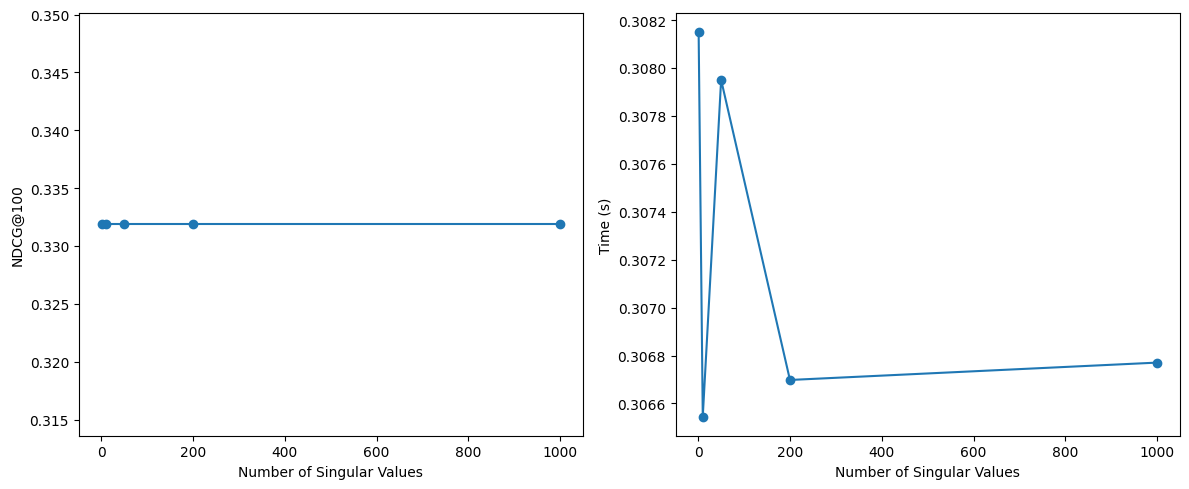

In [22]:
plot_graphs(coo_interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [23]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [24]:
def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    #your code here
    # Инициализация модели ALS
    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha
    )
    
    if isinstance(interactions, np.ndarray):
        interactions = csr_matrix(interactions)
    
    model.fit(interactions)
    
    user_ids = np.arange(interactions.shape[0])
    recommendations = []
    
    for user in user_ids:
        # Получаем кортежи (item_id, score)
        recs = model.recommend(
            userid=user,
            user_items=interactions[user],
            N=top_k,
            filter_already_liked_items=True
        )
        
        # Извлекаем только целочисленные item_id
        valid_item_ids = [int(rec[0]) for rec in recs if rec[0] < interactions.shape[1]]
        
        # Проверяем наличие item_id в кодировщике
        valid_item_ids = [id for id in valid_item_ids if id in item_le.classes_]
        
        # Дополняем до top_k валидными значениями
        if len(valid_item_ids) < top_k:
            valid_item_ids.extend([-1] * (top_k - len(valid_item_ids)))
        
        recommendations.append(valid_item_ids[:top_k])
    
    return np.array(recommendations)

In [25]:
recs_ALS = make_als_recommendations(interactions)
assert recs_ALS.shape == (interactions.shape[0], 100)

c:\Users\krugd\AppData\Local\Programs\Python\Python313\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
def eval_ndcg(recommendations, test_df):
    y_true = test_df.groupby("user_id")["item_id"].apply(list)
    y_pred = [recs_ALS[user] for user in range(recommendations.shape[0])]
    
    ndcg_scores = []
    for user in y_true.index:
        true_items = y_true[user]
        if user >= len(y_pred):
            continue
        pred_items = recommendations[user]
        if len(pred_items) == 0:
            continue
        # Создаем бинарные метки для совпадений
        relevance = np.isin(pred_items, true_items).astype(int)
        if np.sum(relevance) == 0:
            continue
        ndcg = ndcg_score([relevance], [np.arange(len(relevance))], k=100)
        ndcg_scores.append(ndcg)
    return np.mean(ndcg_scores) if ndcg_scores else 0

In [27]:
# Вычисляем NDCG для ALS с параметрами по умолчанию
als_ndcg = eval_ndcg(recs_ALS, df_test)
print(f"ALS NDCG@100 (default): {als_ndcg:.4f}")

ALS NDCG@100 (default): 0.1519


In [28]:
# Вычисляем NDCG для SVD (лучший результат из задания 2.3)
svd_ndcg = eval_ndcg(recs_SVD, df_test)
print(f"SVD NDCG@100: {svd_ndcg:.4f}")

SVD NDCG@100: 0.4877


In [29]:
# Подбор гиперпараметров ALS
param_grid = {
    'n_factors': [50, 100, 200, 300],
    'alpha': [1.0, 10.0, 50.0, 60.0],
    'regularization': [0.01, 0.1, 1.0]
}

In [30]:
best_score_ALS = 0
best_params_ALS = {}

# Перебор комбинаций гиперпараметров
for n_factors in param_grid['n_factors']:
    for alpha in param_grid['alpha']:
        for reg in param_grid['regularization']:
            # Обучение модели
            model = AlternatingLeastSquares(
                factors=n_factors,
                regularization=reg,
                alpha=alpha,
                iterations=15,
                random_state=42
            )
            model.fit(csr_matrix(interactions))
            
            # Получение рекомендаций
            recommendations = make_als_recommendations(
                interactions,
                n_factors=n_factors,
                alpha=alpha,
                regularization=reg
            )
            
            score = eval_ndcg(recommendations, df_test)

            if score > best_score_ALS:
                best_score_ALS = score
                best_params_ALS = {'n_factors': n_factors, 'alpha': alpha, 'regularization': reg}

print(f"\nBest params: {best_params_ALS}")
print(f"Best NDCG@100: {best_score_ALS:.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


Best params: {'n_factors': 200, 'alpha': 60.0, 'regularization': 1.0}
Best NDCG@100: 0.1536


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [31]:
#your code here
movies = pd.read_csv(
    'ml-1m/movies.dat', 
    sep='::', 
    names=['item_id', 'title', 'genre'], 
    engine='python',
    encoding='latin-1'
)

In [32]:
movies.head()

,item_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [33]:
# Инициализация модели ALS
model_ALS = AlternatingLeastSquares(factors = 50, alpha = 60.0, regularization = 0.01)
model_ALS.fit(csr_matrix(interactions))

  0%|          | 0/15 [00:00<?, ?it/s]

In [34]:
def explain_recommendations(user_id, model, movies_df, interactions_matrix, top_n=3):
    # Проверяем, что user_id существует в матрице взаимодействий
    if user_id >= interactions_matrix.shape[0]:
        print(f"Пользователь {user_id} отсутствует в матрице взаимодействий.")
        return
    
    # Получаем взаимодействия для конкретного пользователя
    user_items = csr_matrix(interactions_matrix[user_id].reshape(1, -1))
    
    # Проверяем, что пользователь взаимодействовал хотя бы с одним фильмом
    if user_items.nnz == 0:
        print(f"Пользователь {user_id} не взаимодействовал ни с одним фильмом.")
        return
    
    # Получаем рекомендации
    try:
        recommended_items, scores = model.recommend(
            userid=user_id,
            user_items=user_items,
            N=top_n,
            filter_already_liked_items=True
        )
    except Exception as e:
        print(f"Ошибка при получении рекомендаций для пользователя {user_id}: {e}")
        return
    
    for item_id, score in zip(recommended_items, scores):
        try:
            # Преобразуем внутренний индекс в оригинальный item_id
            original_item_id = item_le.inverse_transform([item_id])[0]
            title = movies_df[movies_df['item_id'] == original_item_id]['title'].values[0]
            print(f" - {title} (score: {score:.2f})")
            
            # Объяснение рекомендации
            result = model.explain(
                userid=user_id,
                user_items=user_items,
                itemid=item_id,
                N=5
            )
            
            # Распаковываем только нужные значения
            total_score, factors = result[0], result[1]
            
            print("   Основные факторы влияния:")
            for factor_id, factor_score in factors:
                try:
                    factor_original_id = item_le.inverse_transform([factor_id])[0]
                    factor_title = movies_df[movies_df['item_id'] == factor_original_id]['title'].values[0]
                    print(f"   * {factor_title} (вклад: {factor_score:.2f})")
                except Exception as e:
                    print(f"   Ошибка при обработке фактора {factor_id}: {e}")
        except Exception as e:
            print(f"Ошибка при обработке фильма {item_id}: {e}")


In [35]:
# Выбираем первых 3 пользователей
for user in range(3):
    explain_recommendations(user, model_ALS, movies, interactions)

 - Straight Story, The (1999) (score: 1.40)
   Основные факторы влияния:
   * Secrets & Lies (1996) (вклад: 0.36)
   * Trip to Bountiful, The (1985) (вклад: 0.26)
   * Almost Famous (2000) (вклад: 0.22)
   * Hard Day's Night, A (1964) (вклад: 0.21)
   * Midnight Cowboy (1969) (вклад: 0.20)
 - Bicycle Thief, The (Ladri di biciclette) (1948) (score: 1.36)
   Основные факторы влияния:
   * Decline of Western Civilization Part II: The Metal Years, The (1988) (вклад: 0.21)
   * Dancer in the Dark (2000) (вклад: 0.20)
   * 400 Blows, The (Les Quatre cents coups) (1959) (вклад: 0.18)
   * Raise the Red Lantern (1991) (вклад: 0.16)
   * Double Indemnity (1944) (вклад: 0.16)
 - Fantasia 2000 (1999) (score: 1.34)
   Основные факторы влияния:
   * Some Like It Hot (1959) (вклад: 0.27)
   * Limbo (1999) (вклад: 0.24)
   * Trip to Bountiful, The (1985) (вклад: 0.24)
   * Dancer in the Dark (2000) (вклад: 0.23)
   * Misérables, Les (1995) (вклад: 0.20)
 - Midnight Cowboy (1969) (score: 1.21)
Ошибка 

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [36]:
#your code here

In [37]:
df_train.head()

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50


In [38]:
df_test.head()

,user_id,item_id,rating,datetime
100406,0,925,4,2000-12-01 00:02:42
100407,0,926,4,2000-12-01 00:03:23
100408,0,2992,3,2000-12-01 00:03:23
100410,0,927,4,2000-12-01 00:02:42
100413,0,936,4,2000-12-01 00:03:23


In [39]:
# Загружаем данные (используем уже готовые df_train и df_test)
def preprocess_data(df_train, df_test, mode="binary", smoothing=False):
    """
    Преобразует данные по выбранному способу:
    - "binary" - все рейтинги заменяются на 1
    - "pos_neg" - рейтинги 4 и 5 -> 1, остальные -> 0
    - "pos_neg_neg" - рейтинги 4 и 5 -> 1, остальные -> -1
    - "time_smooth" - рейтинги 4 и 5 -> 1, остальные -> -1 с учетом времени
    """
    if mode == "binary":
        df_train["rating"] = 1
    elif mode == "pos_neg":
        df_train["rating"] = (df_train["rating"] >= 4).astype(int)
    elif mode == "pos_neg_neg":
        df_train["rating"] = np.where(df_train["rating"] >= 4, 1, -1)
    elif mode == "time_smooth":
        max_time = df_train["datetime"].max()
        df_train["rating"] = np.where(df_train["rating"] >= 4, 1, -1)
        df_train["rating"] *= np.exp(-(max_time - df_train["datetime"]).dt.days / 30)
    
    return df_train 

In [40]:
# Функция создания разреженной матрицы
def create_sparse_matrix(df, num_users, num_items):
    rows, cols, values = df["user_id"], df["item_id"], df["rating"].astype(float)  
    return coo_matrix((values, (rows, cols)), shape=(num_users, num_items))

# Функция для обучения ALS
def train_als(sparse_matrix, factors=20, regularization=0.1, iterations=10):
    model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)
    model.fit(sparse_matrix)
    return model

# Функция для обучения SVD
def train_svd(sparse_matrix, k=20):
    U, sigma, Vt = svds(sparse_matrix, k=k)
    return U, sigma, Vt

In [41]:
def predict_als(model, df_test, num_users, num_items):
    user_items = create_sparse_matrix(df_test, num_users, num_items)
    predictions = []
    actuals = []
    
    for user in df_test["user_id"].unique():
        user_items_indices = df_test[df_test["user_id"] == user]["item_id"].values
        preds = model.recommend(user, user_items, N=len(user_items_indices), filter_already_liked_items=False)

        if not preds:  # Проверяем, что preds не пуст
            predictions.append(np.zeros(num_items))  # Добавляем нулевой вектор
            actuals.append(np.zeros(num_items))
            continue  # Пропускаем пустые предсказания
        
        pred_scores = np.zeros(num_items)

        for pred in preds:
            if isinstance(pred, (tuple, list)) and len(pred) >= 2:
                item, score = int(pred[0]), pred[1]
                if item < num_items:  # Проверяем, чтобы индекс не выходил за границы
                    pred_scores[item] = score
        
        true_scores = np.zeros(num_items)
        true_scores[user_items_indices] = 1  

        predictions.append(pred_scores)
        actuals.append(true_scores)
    
    return predictions, actuals


In [42]:
# Функция для предсказания с SVD
def predict_svd(U, sigma, Vt, df_test):
    preds = np.dot(np.dot(U, np.diag(sigma)), Vt)  # Восстанавливаем матрицу рейтингов
    predictions = []
    actuals = []
    
    for user in df_test["user_id"].unique():
        user_items_indices = df_test[df_test["user_id"] == user]["item_id"].values
        pred_scores = preds[user, :]  # Берем предсказанные значения
        
        true_scores = np.zeros(preds.shape[1])
        true_scores[user_items_indices] = 1  

        predictions.append(pred_scores)
        actuals.append(true_scores)
    
    return predictions, actuals

In [43]:
modes = ["binary", "pos_neg", "pos_neg_neg", "time_smooth"]
results = {}

In [44]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

In [45]:
for mode in modes:
    df_train_processed = preprocess_data(df_train, df_test, mode=mode)
    
    num_users = df_train["user_id"].max() + 1
    num_items = df_train["item_id"].max() + 1
    sparse_matrix = create_sparse_matrix(df_train_processed, num_users, num_items)
    
    als_model = train_als(sparse_matrix)
    svd_model = train_svd(sparse_matrix)
    
    results[mode] = {"ALS": als_model, "SVD": svd_model}
    print(f"Готово: {mode}")

c:\Users\krugd\AppData\Local\Programs\Python\Python313\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01962733268737793 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Готово: binary


c:\Users\krugd\AppData\Local\Programs\Python\Python313\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01935863494873047 seconds
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

ArpackError: ARPACK error -9: Starting vector is zero.

In [ ]:
# Оценка моделей
ndcg_results = {"ALS": [], "SVD": []}

for mode in modes:
    als_model = results[mode]['ALS']
    svd_model = results[mode]['SVD']
    
    als_preds, als_actuals = predict_als(als_model, df_test, num_users, num_items)
    svd_preds, svd_actuals = predict_svd(*svd_model, df_test)
    
    ndcg_als = np.mean([ndcg_score([true], [pred]) for true, pred in zip(als_actuals, als_preds)])
    ndcg_svd = np.mean([ndcg_score([true], [pred]) for true, pred in zip(svd_actuals, svd_preds)])
    
    ndcg_results["ALS"].append(ndcg_als)
    ndcg_results["SVD"].append(ndcg_svd)

    print(f"{mode}: ALS NDCG = {ndcg_als:.4f}, SVD NDCG = {ndcg_svd:.4f}")

binary: ALS NDCG = 0.3849, SVD NDCG = 0.4557
pos_neg: ALS NDCG = 0.3849, SVD NDCG = 0.3849
pos_neg_neg: ALS NDCG = 0.3849, SVD NDCG = 0.3588
time_smooth: ALS NDCG = 0.3849, SVD NDCG = 0.3595


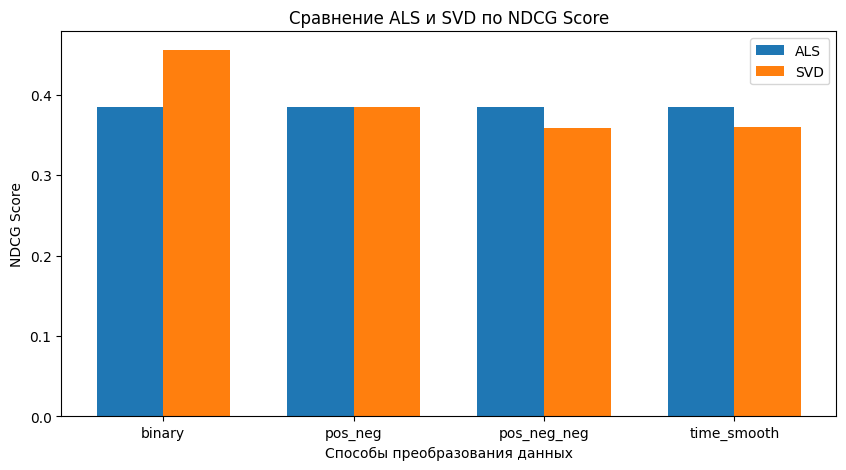

In [ ]:
# Визуализация результатов
x = np.arange(len(modes))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, ndcg_results["ALS"], width, label="ALS")
rects2 = ax.bar(x + width/2, ndcg_results["SVD"], width, label="SVD")

ax.set_xlabel("Способы преобразования данных")
ax.set_ylabel("NDCG Score")
ax.set_title("Сравнение ALS и SVD по NDCG Score")
ax.set_xticks(x)
ax.set_xticklabels(modes)
ax.legend()

plt.show()

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [ ]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        #your code here
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.X = None  # Факторы пользователей
        self.Y = None  # Факторы предметов

    def fit(self, interractions: np.ndarray, n_iterations: int = 10):

        #your code here
        n_users, n_items = interactions.shape

        # Инициализируем матрицы факторов случайными значениями
        self.X = np.random.normal(scale=1.0/self.n_factors, size=(n_users, self.n_factors))
        self.Y = np.random.normal(scale=1.0/self.n_factors, size=(n_items, self.n_factors))

        # Вычисляем матрицу уверенности
        C = 1 + self.alpha * interactions

        # Бинаризуем матрицу предпочтений
        P = (interactions > 0).astype(float)

        for _ in range(n_iterations):
            self._update_users(C, P)
            self._update_items(C, P)

    def _update_users(self, C, P):
        # Обновление матрицы факторов пользователей
        YTY = self.Y.T @ self.Y  # Предвычисляем Y^T Y

        for u in range(C.shape[0]):
            Cu = np.diag(C[u])  # Диагональная матрица C_u
            YT_Cu_Y = YTY + self.Y.T @ (Cu - np.eye(C.shape[1])) @ self.Y
            YT_Cu_Pu = self.Y.T @ Cu @ P[u]
            self.X[u] = np.linalg.solve(YT_Cu_Y + self.reg_coef * np.eye(self.n_factors), YT_Cu_Pu)

    def _update_items(self, C, P):
        # Обновление матрицы факторов айтемов
        XTX = self.X.T @ self.X  # Предвычисляем X^T X

        for i in range(C.shape[1]):
            Ci = np.diag(C[:, i])  # Диагональная матрица C_i
            XT_Ci_X = XTX + self.X.T @ (Ci - np.eye(C.shape[0])) @ self.X
            XT_Ci_Pi = self.X.T @ Ci @ P[:, i]
            self.Y[i] = np.linalg.solve(XT_Ci_X + self.reg_coef * np.eye(self.n_factors), XT_Ci_Pi)

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        #your code here
        scores = self.X @ self.Y.T  # Вычисляем оценки релевантности
        scores[interactions > 0] = -np.inf  # Исключаем уже просмотренные предметы
        recommendations = np.argsort(-scores, axis=1)[:, :top_k]
        return recommendations # shape ~ [n_users, top_k]